# Определение тарифа для телеком компании

## Содержание
1. [Описание проекта](#step1)
2. [Изучение общей информации](#step2)
3. [Подготовка данных](#step3)  
 - Работа с пропущенными значениями  
 - Приведение данных к нужному типу  
 - Расчёты  
4. [Исследование поведения клиентов оператора](#step4)
 
5. [Проверка гипотез](#step5)  

  1. Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются
  2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
6. [Общий вывод](#step6)
  
  
 

<a id='step1'></a>

## 1. Описание проекта

### Задача
— проанализировать поведение клиентов и сделать вывод — какой тариф лучше.   

### Данные:
Данные о 500 пользователей телеком-компании: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

**Таблица users (информация о пользователях):**  
user_id — уникальный идентификатор пользователя  
first_name — имя пользователя  
last_name — фамилия пользователя  
age — возраст пользователя (годы)  
reg_date — дата подключения тарифа (день, месяц, год)  
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
city — город проживания пользователя  
tariff — название тарифного плана  

**Таблица calls (информация о звонках):**  
id — уникальный номер звонка  
call_date — дата звонка  
duration — длительность звонка в минутах  
user_id — идентификатор пользователя, сделавшего звонок  

**Таблица messages (информация о сообщениях):**  
id — уникальный номер сообщения  
message_date — дата сообщения  
user_id — идентификатор пользователя, отправившего сообщение  

**Таблица internet (информация об интернет-сессиях):**  
id — уникальный номер сессии  
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
session_date — дата интернет-сессии  
user_id — идентификатор пользователя  

**Таблица tariffs (информация о тарифах):**  
tariff_name — название тарифа  
rub_monthly_fee — ежемесячная абонентская плата в рублях  
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
messages_included — количество сообщений в месяц, включённых в абонентскую плату  
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  


### Описание тарифов:  
**Тариф "Смарт"**  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  

**Тариф "Ультра"**  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  

\* компания всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.


[К содержанию](#Содержание)
<a id='step2'></a>

## 2. Изучение общей информации

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
print('Количество звонков с нулевой продолжительностью: {}, что составляет {:.2%} от \
общего числа звонков'
      .format(calls[calls.duration == 0].shape[0], calls[
          calls.duration == 0].shape[0]/calls.shape[0]))

Количество звонков с нулевой продолжительностью: 39613, что составляет 19.55% от общего числа звонков


В таблице `calls` нет явных пропущенных значений, но довольно много звонков с нулевой продолжительностью. Возможно, это пропущенные звонки. В любом случае, поскольку на расчёт выручки они не повлияют, можно такие данные удалить.  
Переменную `call_date` необходимо перевести в формат datetime.  

In [6]:
internet = pd.read_csv('/datasets/internet.csv', index_col=0)

In [7]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [9]:
internet.mb_used.describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [10]:
print('Количество сессий с нулевым значением потраченного трафика: {}, что составляет \
{:.2%} от общего числа сессий'
      .format(internet[internet.mb_used == 0].shape[0], 
              internet[internet.mb_used == 0].shape[0]/internet.shape[0]))

Количество сессий с нулевым значением потраченного трафика: 19598, что составляет 13.12% от общего числа сессий


Аналогично звонкам, из таблицы `internet` придётся удалить строки с нулевым потраченным трафиком.  
Дату сессий перевести в формат datetime.  

In [11]:
messages = pd.read_csv('/datasets/messages.csv')

In [12]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице `messages` пропущенных значений нет, дату пререведём в datetime.  

In [14]:
tariffs = pd.read_csv('/datasets/tariffs.csv', index_col=-1)

In [15]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
tariff_name,,,,,,,
smart,50,15360,500,550,200,3,3
ultra,1000,30720,3000,1950,150,1,1


In [16]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, smart to ultra
Data columns (total 7 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
dtypes: int64(7)
memory usage: 128.0+ bytes


In [17]:
users = pd.read_csv('/datasets/users.csv', index_col=0)

In [18]:
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 7 columns):
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(1), object(6)
memory usage: 31.2+ KB


В таблице `users` пропущенные значения есть только в столбце `churn_date`, но поскольку, как следует из описания, это означает только то, что тариф ещё действовал на дату выгрузки данных, оставим эти данные как есть.  

### Вывод
В данных обнаружено много нулевых значений продолжительности звонков и использованных за сесию мегабайт (19.55% и 13.12% от общего числа наблюдений соответственно). Поскольку в рамках проекта выяснить причину пропусков или как-то восстановить эти данные не представляется возможным, а в расчете выручки их использовать бесполезно, такие данные будут удалены.  
Все данные по датам необходимо перевести в формат datetime.

[К содержанию](#Содержание)
<a id='step3'></a>

## 3. Подготовка данных

### Работа с пропущенными значениями
Удалим бесполезные нулевые данные из таблиц `calls` и `internet`

In [20]:
calls = calls.query('duration > 0')
interntet = internet.query('mb_used > 0')

### Приведение данных к нужному типу  
Переведём все даты в формат datetime (кроме `churn_date`, в которой оставлены пропущенные значения)

In [21]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])

### Расчёты
Рассчитаем для каждого пользователя:  
 - количество сделанных звонков и израсходованных минут разговора по месяцам

In [22]:
#Добавляем в таблицу колонку с месяцем звонка
calls['month'] = calls['call_date'].apply(lambda d: d.month)

In [23]:
calls_per_month = calls.pivot_table(index=['user_id', 'month'],
                                   values='id', aggfunc='count')
calls_per_month.columns = ['calls']
calls_per_month.head()

calls
user_id month       
1000    5         17
        6         28
        7         41
        8         42
        9         46

Поскольку оператор округляет вверх значения минут, добавим в таблицу `calls` столбец `duration_rnd`  и будем считать израсходованные минуты по нему.

In [24]:
calls['duration_rnd'] = calls['duration'].apply('ceil')

In [25]:
minutes_per_month = calls.pivot_table(index=['user_id', 'month'],
                                   values='duration_rnd', aggfunc='sum')
minutes_per_month.columns = ['minutes']
minutes_per_month.head()

minutes
user_id month         
1000    5        159.0
        6        172.0
        7        340.0
        8        408.0
        9        466.0

- количество отправленных сообщений по месяцам

In [26]:
#Добавляем месяц отправки сообщения
messages['month'] = messages['message_date'].apply(lambda d: d.month)

In [27]:
messages_per_month = messages.pivot_table(index=['user_id', 'month'],
                                      values='id', aggfunc='count')
messages_per_month.columns = ['messages']
messages_per_month.head()

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57

 - объем израсходованного интернет-трафика по месяцам

In [28]:
#Добавляем месяц сессии
internet['month'] = internet['session_date'].apply(lambda d: d.month)

Поскольку оператор округляет вверх значения мегабайтов, добавим столбец `mb_used_rnd`  и будем считать объём израсходованного трафика по нему.

In [29]:
internet['mb_used_rnd'] = internet['mb_used'].apply('ceil')

In [30]:
mb_per_month = internet.pivot_table(index=['user_id', 'month'], 
                                      values='mb_used_rnd', aggfunc='sum')
mb_per_month.columns = ['mbs']
mb_per_month.head()

mbs
user_id month         
1000    5       2256.0
        6      23257.0
        7      14016.0
        8      14070.0
        9      14581.0

Объединяем таблицы в одну.

In [31]:
users_monthly_activity = calls_per_month.merge(minutes_per_month, how='outer', 
                                                      left_index=True,
                                               right_index=True).merge(
messages_per_month, how='outer',
                                                      left_index=True,
                                                     right_index=True).merge(
mb_per_month, how='outer',
                                                     left_index=True,
                                                     right_index=True)

In [32]:
#Поскольку в таблице могут быть месяцы, когда пользователи, например, совершали звонки, но не 
#отправляли сообщений, могут появиться пропущенные значения. Заполним их нулями.
users_monthly_activity = users_monthly_activity.fillna(0)

In [33]:
users_monthly_activity.head()

calls  minutes  messages      mbs
user_id month                                   
1000    5       17.0    159.0      22.0   2256.0
        6       28.0    172.0      60.0  23257.0
        7       41.0    340.0      75.0  14016.0
        8       42.0    408.0      81.0  14070.0
        9       46.0    466.0      57.0  14581.0

Рассчитаем помесячную выручку с каждого пользователя:
1. Выручка от минут разговора сверх лимита

In [34]:
users_monthly_activity = users_monthly_activity.reset_index()

In [35]:
#Добавляем информацию об используемом тарифе для каждого пользователя
users_monthly_activity = users_monthly_activity.join(users['tariff'], on='user_id')

In [36]:
#Добавляем необходимую для вычислений информацию о тарифах
users_monthly_activity = users_monthly_activity.join(tariffs, on='tariff')

In [37]:
#Рассчитывем выручку от использованных сверх лимита минут, сообщений и мегабайтов
users_monthly_activity['paid_minutes'] = ((users_monthly_activity['minutes'] - \
users_monthly_activity['minutes_included'])*users_monthly_activity['rub_per_minute']).where(
users_monthly_activity['minutes'] > users_monthly_activity['minutes_included'], 0)
users_monthly_activity['paid_messages'] = ((users_monthly_activity['messages'] - \
users_monthly_activity['messages_included'])*users_monthly_activity['rub_per_message']).where(
users_monthly_activity['messages'] > users_monthly_activity['messages_included'], 0)
users_monthly_activity['paid_mbs'] = (users_monthly_activity['mbs'] - \
users_monthly_activity['mb_per_month_included'])*(users_monthly_activity['rub_per_gb']/1024).where(
users_monthly_activity['mbs'] > users_monthly_activity['mb_per_month_included'], 0)

In [38]:
#Рассчитываем общую выручку с учётом абонентской платы
users_monthly_activity['total_revenue'] = (users_monthly_activity['paid_minutes'] + \
users_monthly_activity['paid_messages'] + \
users_monthly_activity['paid_mbs'] + users_monthly_activity['rub_monthly_fee']).round(2)

In [39]:
users_monthly_activity

,user_id,month,calls,minutes,messages,mbs,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mbs,total_revenue
0,1000,5,17.0,159.0,22.0,2256.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,-0.000000,1950.00
1,1000,6,28.0,172.0,60.0,23257.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,-0.000000,1950.00
2,1000,7,41.0,340.0,75.0,14016.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,-0.000000,1950.00
3,1000,8,42.0,408.0,81.0,14070.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,-0.000000,1950.00
4,1000,9,46.0,466.0,57.0,14581.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,-0.000000,1950.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10,30.0,247.0,42.0,20604.0,smart,50,15360,500,550,200,3,3,0.0,0.0,1024.218750,1574.22
3210,1499,9,8.0,70.0,11.0,1848.0,smart,50,15360,500,550,200,3,3,0.0,0.0,-0.000000,550.00
3211,1499,10,44.0,449.0,48.0,17809.0,smart,50,15360,500,550,200,3,3,0.0,0.0,478.320312,1028.32
3212,1499,11,62.0,612.0,59.0,17984.0,smart,50,15360,500,550,200,3,3,336.0,27.0,512.500000,1425.50


### Вывод
Данные о звонках и используемом трафике с нулевыми значениями удалены.  
Все переменные, содержащие даты, переведены в формат datetime.  
Рассчитана помесячная выручка по каждому пользователю: столбец `total_revenue` в таблице `users_monthly_activity`.  

[К содержанию](#Содержание)
<a id='step4'></a>

## 4. Исследование поведения клиентов оператора

Определим, сколько минут разговора, сообщений и мегабайт трафика требуется пользователям каждого тарифа в месяц. Для этого рассчитаем медианные значения этих переменных за год. Также проведем исследование выручки.

In [40]:
median_data_smart = users_monthly_activity.query('tariff=="smart"').groupby('user_id')[
    'minutes', 'messages', 'mbs', 'total_revenue'].median()
median_data_ultra = users_monthly_activity.query('tariff=="ultra"').groupby('user_id')[
    'minutes', 'messages', 'mbs', 'total_revenue'].median()
median_data_ultra.head()

,minutes,messages,mbs,total_revenue
user_id,,,,
1000,339.0,65.0,14325.5,1950.0
1003,824.0,83.0,11368.0,1950.0
1004,132.5,154.5,17828.5,1950.0
1013,468.0,21.0,15272.5,1950.0
1016,61.0,71.0,13417.0,1950.0


Рассчитаем среднее количество, дисперсию и стандартное отклонение полученных значений, а также построим гистограммы.  
Поскольку дисперсия и стандартное отклонение считаются по выборке, а не по всем пользователям, принимаем параметр ddof=1.

In [41]:
#Функция для расчёта статистик
def user_stats(x):
    var_smart = np.var(median_data_smart[x], ddof=1)
    var_ultra = np.var(median_data_ultra[x], ddof=1)                      
    std_smart = np.std(median_data_smart[x], ddof=1)
    std_ultra = np.std(median_data_ultra[x], ddof=1) 
    avg_smart = np.mean(median_data_smart[x])
    avg_ultra = np.mean(median_data_ultra[x])
    print(pd.DataFrame(index=['smart', 'ultra'],
            data=[[avg_smart, var_smart, std_smart],
                 [avg_ultra, var_ultra, std_ultra]],
            columns=['Среднее', 'Дисперсия', 'Стандартное отклонение']).round(2))

In [42]:
#Фуекция для посторения и сравнения гистограмм пользователей разных тарифов
def compare_distributions(x, text):
    ax = median_data_smart[x].plot(kind='hist', bins=50,
                                             alpha=0.7, 
                                             color='blue', label='smart', legend=True)
    median_data_ultra[x].plot(kind='hist', bins=50, 
                                        ax=ax, alpha=0.7, color='red',
                                       label='ultra', legend=True)
    plt.title('Гистограммы распределения '+text);

**Минуты разговора**

In [43]:
user_stats('minutes')

       Среднее  Дисперсия  Стандартное отклонение
smart   437.47   25685.39                  160.27
ultra   557.50   92290.58                  303.79


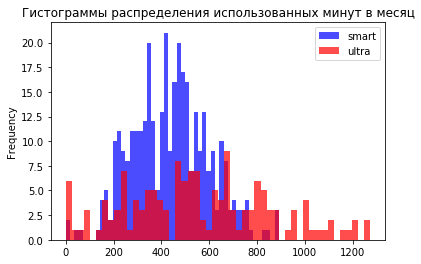

In [44]:
compare_distributions('minutes', 'использованных минут в месяц')

Распределения по форме напоминают нормальные. Среди пользователей тарифа ultra больше разброс значений. Тариф "Ультра" включает 3000 минут, но по гистограмме видно, что очень немногие пользователи используют и половину этого лимита.

**Количество сообщений**

In [45]:
user_stats('messages')

       Среднее  Дисперсия  Стандартное отклонение
smart    33.77     784.60                   28.01
ultra    56.98    2424.26                   49.24


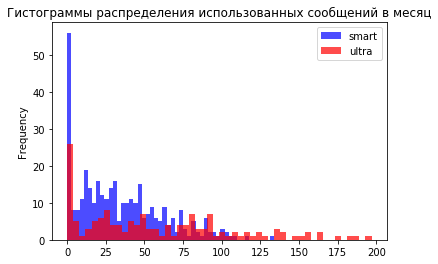

In [46]:
compare_distributions('messages', 'использованных сообщений в месяц')

Распределения похожи по форме и скошены вправо. У пользователя тарифа ultra больше разброс значений. Как и в случае с минутами видно, что у тарифа "Ультра" очень большой лимит. Люди не отправляют больше 200 сообщений в месяц при включённом в тариф лимите в 1000.

**Объём трафика в мегабайтах**

In [47]:
user_stats('mbs')

        Среднее    Дисперсия  Стандартное отклонение
smart  16853.83  17468577.21                 4179.54
ultra  20322.49  79230804.25                 8901.17


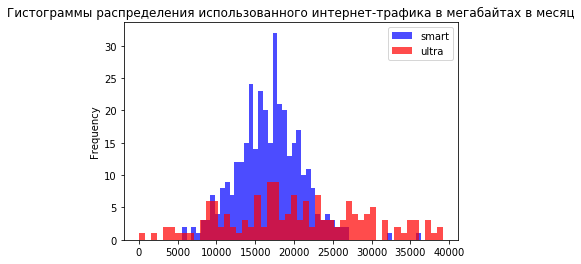

In [48]:
compare_distributions('mbs','использованного интернет-трафика в мегабайтах в месяц')

Распределения объема трафика напоминают нормальные, разброс значений и пользователей ultra больше.

**Общая выручка**

In [49]:
user_stats('total_revenue')

       Среднее  Дисперсия  Стандартное отклонение
smart  1240.53  493162.58                  702.26
ultra  2050.23   75463.46                  274.71


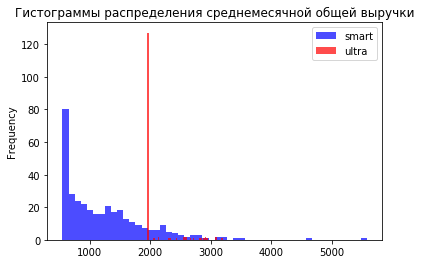

In [50]:
compare_distributions('total_revenue', 'среднемесячной общей выручки')

На гистограмме видно, что пользователи тарифа "Ультра" приносят выручку как правило за счет абонентской платы. Очень немногие клиенты превышают установленные лимиты.

Рассчитаем общую суммарную выручку по выборке.

In [51]:
revenue_sums = users_monthly_activity.groupby('tariff')['total_revenue'].sum()
revenue_sums

tariff
smart    2749135.84
ultra    2029622.05
Name: total_revenue, dtype: float64

In [52]:
print('Разница в суммарной выручке за 2018 год составляет {:.2f} рублей.'.format(
    abs(revenue_sums.smart - revenue_sums.ultra)))

Разница в суммарной выручке за 2018 год составляет 719513.79 рублей.


Расчёт говорит о том, что пользователи тарифа "Смарт" приносят большую выручку. 

### Вывод
Распределения использованных минут разговора, сообщений и мегабайт трафика у тарифов "Смарт" и "Ультра" похожи по форме, но значения у пользователей "Ультра" имеют больший разброс.  
Это связано с тем, что у тарифа ultra гораздо большие лимиты. Кроме того, в выборке пользователей тарифа "Ультра" меньше.  
Суммарно в 2018 году пользователи тарифа "Смарт" принесли большую выручку, чем пользователи тарифа "Ультра".

In [53]:
users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

[К содержанию](#Содержание)
<a id='step5'></a>

## 5. Проверка гипотез

### А. Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются

Найдём среднее выборочное общей выручки для каждого тарифа

In [54]:
avg_smart = users_monthly_activity.loc[
    users_monthly_activity['tariff']=="smart", 'total_revenue'].mean()

In [55]:
avg_ultra = users_monthly_activity.loc[
    users_monthly_activity['tariff']=="ultra", 'total_revenue'].mean()

In [56]:
print('Пользователи тарифа "Смарт" в 2018 году в среднем приносили выручку {:.2f} \
р. в месяц'.format(avg_smart))
print('Пользователи тарифа "Ультра" в 2018 году в среднем приносили выручку {:.2f} \
р. в месяц'.format(avg_ultra))
print('Разница в выручке составляет {:.2f} р. в месяц'.format(abs(
    avg_smart - avg_ultra)))

Пользователи тарифа "Смарт" в 2018 году в среднем приносили выручку 1233.35 р. в месяц
Пользователи тарифа "Ультра" в 2018 году в среднем приносили выручку 2060.53 р. в месяц
Разница в выручке составляет 827.18 р. в месяц


Нулевая гипотеза $H_0$: средняя выручка пользователей тарифов "Смарт" и "Ультра" не отличается.  
Альтернативная гипотеза $H_1$: средняя выручка пользователей тарифов "Смарт" и "Ультра" отличается.  
Пороговое значение $\alpha$ принимаем равным 5%  
    Поскольку в обоих случаях будут проверяться гипотезы о равенстве средних двух генеральных совокупностей, используем метод ttest_ind.


In [57]:
alpha = .05

In [58]:
results = st.ttest_ind(users_monthly_activity.loc[
    users_monthly_activity['tariff']=="smart", 'total_revenue'],
                       users_monthly_activity.loc[
    users_monthly_activity['tariff']=="ultra", 'total_revenue'],
            equal_var=False)

In [59]:
if results.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
    print('Пользователи тарифов "Ультра" и "Смарт" приносят разную выручку')
else:
    print('Нулевая гипотеза не отвергается.')
    print('Выручка от пользователей тарифов "Ультра" и "Смарт" не различается')

Нулевая гипотеза отвергается.
Пользователи тарифов "Ультра" и "Смарт" приносят разную выручку


### B. Средняя выручка пользователей из Москвы отличается от пользователей других городов

In [60]:
users_monthly_activity = users_monthly_activity.join(users['city'], on='user_id')

In [61]:
avg_moscow = users_monthly_activity.loc[
    users_monthly_activity['city']=="Москва", 'total_revenue'].mean()

In [62]:
avg_others = users_monthly_activity.loc[
    users_monthly_activity['city']!="Москва", 'total_revenue'].mean()

In [63]:
print('Пользователи из Москвы в 2018 году в среднем приносили выручку {:.2f} \
р. в месяц'.format(avg_moscow))
print('Пользователи из других городов в 2018 году в среднем приносили выручку {:.2f} \
р. в месяц'.format(avg_others))
print('Разница в выручке составляет {:.2f} р. в месяц'.format(abs(
    avg_moscow - avg_others)))

Пользователи из Москвы в 2018 году в среднем приносили выручку 1507.28 р. в месяц
Пользователи из других городов в 2018 году в среднем приносили выручку 1482.06 р. в месяц
Разница в выручке составляет 25.21 р. в месяц


Нулевая гипотеза $H_0$: средняя выручка пользователей из Москвы и пользователей из других городов не отличается.  
Альтернативная гипотеза $H_1$: средняя выручка пользователей из Москвы и пользователей из других городов отличается.  
Пороговое значение $\alpha$ принимаем равным 5%

In [64]:
results = st.ttest_ind(users_monthly_activity.loc[
    users_monthly_activity['city']=="Москва", 'total_revenue'],
                                 users_monthly_activity.loc[
    users_monthly_activity['city']!="Москва", 'total_revenue'],
            equal_var=False)

In [65]:
if results.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
    print('Пользователи из Москвы и пользователи из других городов приносят разную выручку')
else:
    print('Нулевая гипотеза не отвергается.')
    print('Выручка от пользователей из Москвы и пользователей из других городов не различается.')

Нулевая гипотеза не отвергается.
Выручка от пользователей из Москвы и пользователей из других городов не различается.


[К содержанию](#Содержание)
<a id='step5'></a>

## 5. Общий вывод

Пользователи тарифа "Ультра" приносят выручку в основном в виде абонентской платы. Для количества звонков и сообщений тарифа установлены такие лимиты, которые сложно превысить.  
Пользователи тарифа "Смарт" суммарно за 2018 год принесли на 719513,79 рублей больше. При этом в среднем пользователи тарифа "Ультра" приносят на 812,18 рублей больше, и эта разница является статистически значимой.  
Статистически значимой разницы в выручке от клиентов из Москвы и от клиентов из других городов не выявлено.

[К содержанию](#Содержание)